In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import sys

os.chdir("../..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import sklearn.metrics as metrics
import torch
from ray import air, tune
from ray.air import session

import flippers
from examples.Experiments._vae import WeakLabelVAE

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.notebook_utils import load_wrench_dataset, MetricsMaker

In [6]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
Best_Configs = {}
Results = {}
Metrics = {}

In [7]:
from examples.notebook_utils import dataset_to_metric

In [8]:
%%time

# Define a search space and initialize the search algorithm.
search_space = {
    "latent_dim": tune.grid_search([0, 4, 16, 1000]),
    "learning_rate": tune.grid_search([5e-4, 1e-3, 1e-4]),
    "num_batches": tune.grid_search([500, 2500, 5000]),  # 1000, 5000]),
    "nudge": tune.grid_search([1, 1e-1, 1e-2]),
    "batch_size": 32,  # tune.grid_search([32, 64, 128]),
}

for dataset in datasets:
    data, weak_labels, polarities = load_wrench_dataset(dataset)
    train, dev, test = data
    L_train, L_dev, L_test = weak_labels
    del train

    y_dev = dev["label"].values.astype(int)
    y_test = test["label"].values.astype(int)

    class_balances = list(
        dev["label"].astype(int).value_counts(normalize=True).sort_index()
    )
    MetricsDev = MetricsMaker(L=L_dev, y_true=y_dev)

    # Wrap SnorkelModel in an objective function
    def objective(config):
        m = WeakLabelVAE(
            polarities=polarities,
            class_balances=class_balances,
            latent_dim=config["latent_dim"],
        )
        m.fit(L_train, **config)
        scores = MetricsDev.score(m, plots=False)  # Compute validation metrics
        scores["model"] = m
        session.report(scores)  # Report to Tune

    # Start a Tune run that maximizes metric on dev set
    tuner = tune.Tuner(
        tune.with_resources(objective, {"cpu": 2, "gpu": 0.1}),
        param_space=search_space,
        run_config=air.RunConfig(progress_reporter=tune.JupyterNotebookReporter()),
    )
    results = tuner.fit()

    metric = dataset_to_metric[dataset]
    best_result = results.get_best_result(metric=metric, mode="max")
    Best_Configs[dataset] = best_result.config
    Results[dataset] = results

    m = best_result.metrics["model"]
    # config = best_result.config
    # m = WeakLabelVAE(polarities=polarities, class_balances=class_balances, latent_dim=config["latent_dim"])
    # m.fit(L_train, **config)

    Metrics[dataset] = MetricsMaker(L=L_test, y_true=y_test).score(m, plots=False)

Epoch [3/3]: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s, Loss=12.2]


Trial name,AUC,Accuracy,Average_Precision,Balanced_Accuracy,F1,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,model,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_7cccf_00001,0.893,0.889,0.853,0.881,0.861,2023-05-21_13-10-24,False,,53bff53780b5471f8177951c79c4e07e,LAPTOP,1,"WeakLabelVAE( (encoder): Sequential( (0): Linear(in_features=12, out_features=6, bias=True) (1): ReLU() (2): Linear(in_features=6, out_features=9, bias=True) ) (decoder_mu): Sequential( (0): Linear(in_features=5, out_features=12, bias=True) (1): ReLU() (2): Linear(in_features=12, out_features=12, bias=True) (3): Sigmoid() ) )",127.0.0.1,24112,1.79028,1.79028,1.79028,1684699824,0,,1,7cccf_00001,0.00799942


CPU times: total: 1min 58s
Wall time: 34min 37s


In [11]:
df = pd.DataFrame(Metrics)


# Formatting function to underline entries
def underline_entries(x):
    is_metric = x.index == dataset_to_metric[x.name]
    return ["text-decoration: underline" if v else "" for v in is_metric]


# Underlines the metrics used in the wrench benchmark
df.style.apply(underline_entries).format("{:.3f}")

,cdr,yelp,youtube,census,spouse,basketball,sms,tennis
F1,0.680,0.764,0.836,0.626,0.458,0.183,0.134,0.782
Average_Precision,0.656,0.802,0.914,0.541,0.301,0.124,0.141,0.768
AUC,0.844,0.779,0.883,0.832,0.788,0.530,0.502,0.875
Accuracy,0.714,0.738,0.860,0.777,0.889,0.101,0.794,0.835
Balanced_Accuracy,0.772,0.735,0.854,0.781,0.749,0.500,0.509,0.846


In [12]:
pd.DataFrame(Best_Configs)

,cdr,yelp,youtube,census,spouse,basketball,sms,tennis
latent_dim,4.000,16.0000,1000.000,4.000,4.0000,1000.0000,1000.000,16.0000
learning_rate,0.001,0.0005,0.001,0.001,0.0001,0.0005,0.001,0.0005
num_batches,500.000,5000.0000,2500.000,2500.000,2500.0000,500.0000,2500.000,500.0000
nudge,0.010,0.0100,0.010,1.000,1.0000,1.0000,0.010,0.0100
batch_size,32.000,32.0000,32.000,32.000,32.0000,32.0000,32.000,32.0000


# Inspect best hyperparameter value per model

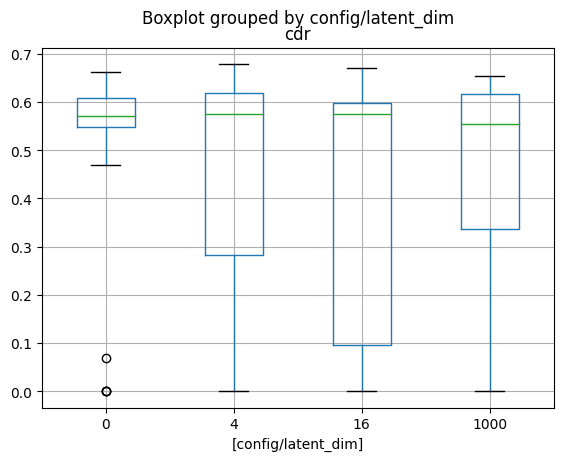

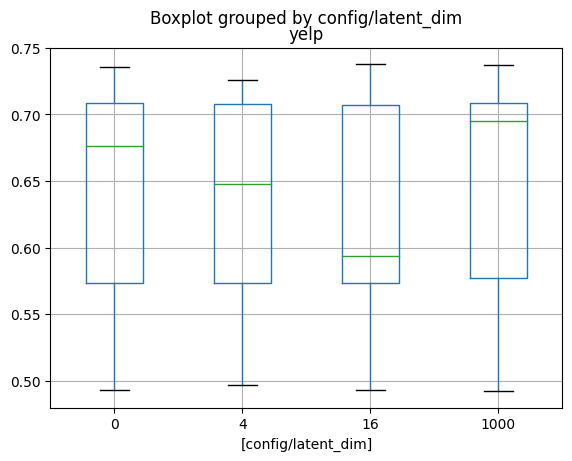

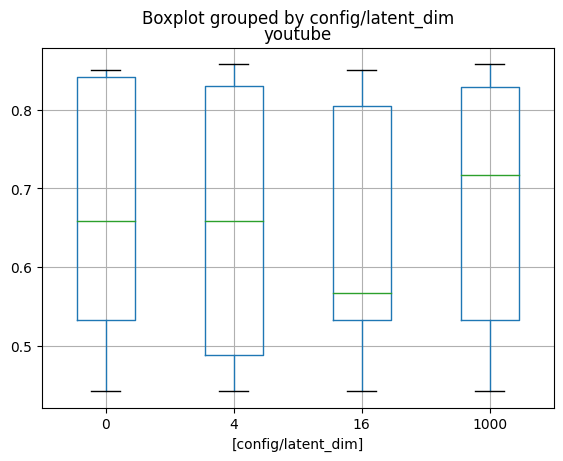

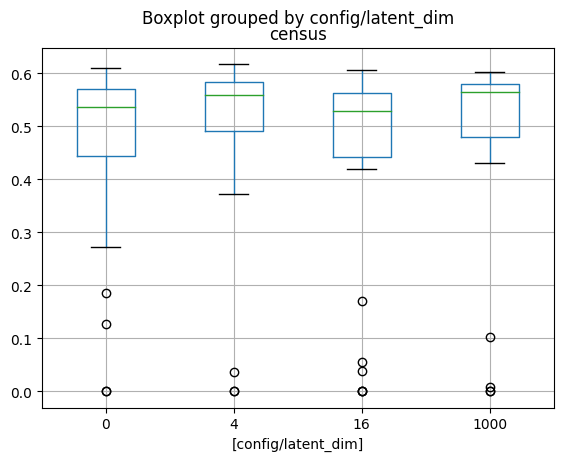

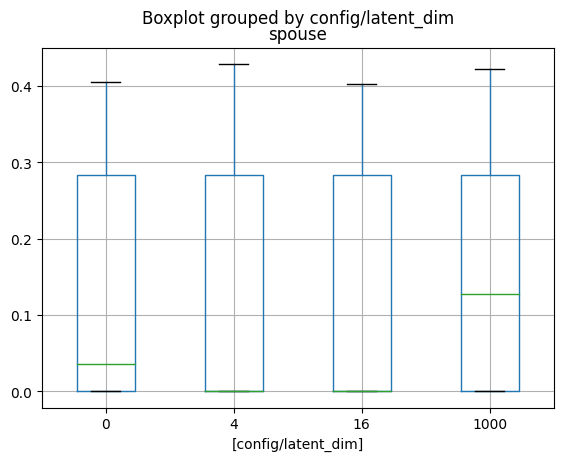

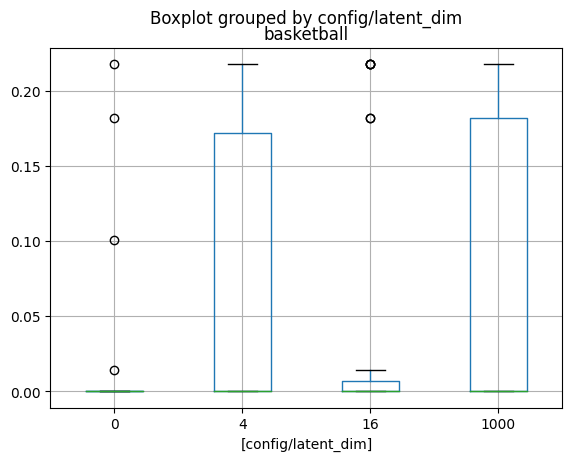

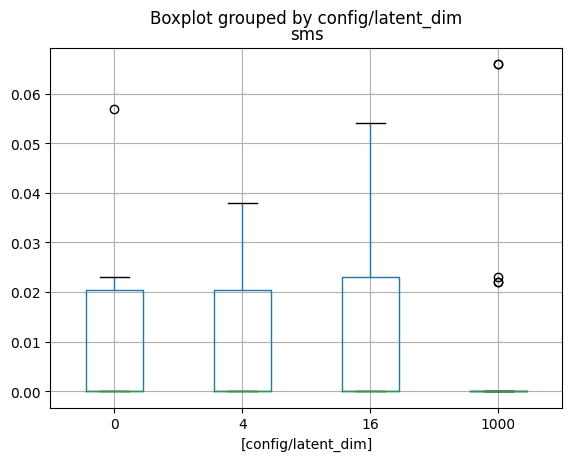

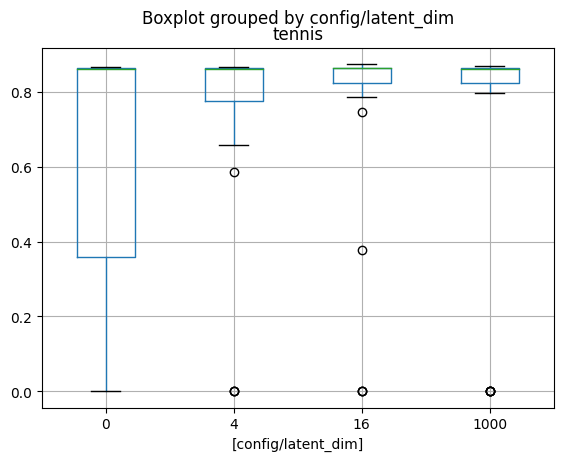

In [13]:
for dataset in datasets:
    grid = Results[dataset]
    grid = grid.get_dataframe()
    # grid = grid[grid["config/k"] == 0]
    hparam = "latent_dim"
    hparam = "config/" + hparam
    grid[[dataset_to_metric[dataset], hparam]].boxplot(by=hparam)
    plt.title(dataset)